# CARS recommender system
Implementation of the deep NN model described in the paper "Context-Aware Recommendations Based on Deep
Learning Frameworks".
https://dl.acm.org/doi/10.1145/3386243

Datasets:
- frappe


## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split dataset in two parts
from sklearn.model_selection import KFold # to split dataset using  k-fold cross validation
from sklearn.metrics import * # evaluation metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt # for creating chart
import requests # for downloading the dataset
from collections import deque # queue data structure
from scipy.cluster.hierarchy import * # for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
import itertools
from sklearn.decomposition import PCA
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate



## Some functions



In [2]:
# plot loss based on history of model.fit, ymin and ymax are the minimum and maximum values of the y axis
def plot_loss(history, ymin=0, ymax=1):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([ymin, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# plot chart of true values on predictions
def plot_predictions(test_y, pred_y):
  a = plt.axes(aspect='equal')
  plt.scatter(test_y, pred_y)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  lims = [0, 5]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

def sigmoid(x):
   return 1 / ( 1 + np.exp(-x))

# k-fold cross validation object
kf = KFold(n_splits=2, random_state=42, shuffle=True)

def kfold_train(model, epochs, batch_size, verbose, df, x_labels, y_label, 
                kf, using_context=False, context_labels=None):
    '''
    Train a model using K-fold CV

    Parameters:
        model: the model to be trained
        epochs: training epochs for each fold
        batch_size: batch size for each fold
        verbose: show training batch and loss
        df: the dataframe on which the model will be trained
        x_labels: features labels
        y_label: desired output labels
        using_context: if the model incorporates context
        context_labels: contextual features labels
        kf: sklearn kfold object
    '''
    idx = 0
    rmse = np.empty(kf.n_splits)
    mae = np.empty(kf.n_splits)

    for train_index, test_index in kf.split(df):
        print(f'Training on fold {idx}...')
        train_x = df.loc[train_index, x_labels]  # get a dataset subset with df.loc[rows, columns]
        train_y = df.loc[train_index, y_label]
        if using_context: # if the model supports contextual features
            train_context = df.loc[train_index, context_labels]
            model.fit([train_x.user, train_x.item, train_context], train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        else:
            model.fit([train_x.user, train_x.item], train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print(f'Testing on fold {idx}...')
        test_x = df.loc[test_index, x_labels]
        test_y = df.loc[test_index, y_label]
        if using_context:
            test_context = df.loc[test_index, context_labels]
            pred_y = model.predict([test_x.user, test_x.item, test_context]).flatten()
        else:
            pred_y = model.predict([test_x.user, test_x.item]).flatten()

        rmse[idx] = mean_squared_error(test_y, pred_y, squared = False)
        mae[idx] = mean_absolute_error(test_y, pred_y)
        print(f'RMSE = {rmse[idx]}    MAE = {mae[idx]}')

        idx = idx + 1
    
    return np.mean(rmse), np.mean(mae)


## Dataset

### Load dataset

In [3]:
# download the dataset
url = 'https://raw.githubusercontent.com/CriptHunter/tesi/master/CARS_DL/frappe/frappe.csv'
req = requests.get(url, allow_redirects=True)
open('frappe.csv', 'wb').write(req.content)

6313241

In [4]:
# open the dataset
df = pd.read_csv('/content/frappe.csv', sep="\t")
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


In [5]:
# count unique values for each column
display("------ unique values ------")
display(df.nunique())

# count number of unknown values for each column
display("------ unknown values ------")
display(df.isin(['unknown']).sum(axis=0))

# count number of zero values for each column (for city 0 == unknown)
display("------ zero values ------")
display(df.isin([0]).sum(axis=0))

'------ unique values ------'

user          957
item         4082
cnt          1981
daytime         7
weekday         7
isweekend       2
homework        3
cost            2
weather         9
country        80
city          233
dtype: int64

'------ unknown values ------'

user             0
item             0
cnt              0
daytime          0
weekday          0
isweekend        0
homework     75670
cost             0
weather      12529
country       7025
city             0
dtype: int64

'------ zero values ------'

user            25
item           521
cnt              0
daytime          0
weekday          0
isweekend        0
homework         0
cost             0
weather          0
country          0
city         38052
dtype: int64

### Dataset preprocessing

In [6]:
# log transformation on the raw frequency numbers that represent the applications usage
df['cnt'] = df['cnt'].apply(np.log10)
f"frequency range is {df['cnt'][df['cnt'] == df['cnt'].min()].values[0]} to {df['cnt'][df['cnt'] == df['cnt'].max()].values[0]}"

# delete columns that are not needed
del df['homework']
del df['cost']
del df['city']
del df['isweekend']
del df['country']

In [7]:
# delete rows where weather is unknown
df = df[df.weather != 'unknown']
df = df.reset_index(drop=True)

# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]

df

,user,item,cnt,daytime,weekday,weather
0,0,0,0.000000,morning,sunday,sunny
1,1,1,0.845098,afternoon,saturday,cloudy
2,2,2,0.778151,evening,monday,cloudy
3,3,3,2.631444,night,thursday,sunny
4,4,4,0.778151,sunset,saturday,sunny
...,...,...,...,...,...,...
83669,96,0,0.698970,evening,sunday,sunny
83670,30,33,2.004321,sunset,sunday,cloudy
83671,156,26,2.385606,afternoon,sunday,cloudy
83672,399,672,0.000000,evening,sunday,sunny


In [8]:
x_labels = ['user', 'item']
y_label = 'cnt'
context_labels = ['daytime', 'weekday', 'weather']

# convert categorical data to one-hot encoding
for col in context_labels:
  df = pd.get_dummies(df, columns=[col], prefix = [col])

# new context labels after one-hot encoding are columns from 3 to the end
context_labels = df.columns[3:]
df

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [9]:
# count number of unique users and items
n_users, n_items = len(df.user.unique()), len(df.item.unique())
n_context = len(context_labels)

f'Number of users: {n_users}      Number of apps: {n_items}     Number of context features: {n_context}'

'Number of users: 862      Number of apps: 3663     Number of context features: 22'

### Latent context extraction


#### With autoencoder

In [10]:
train_context_AE, test_context_AE = train_test_split(df.loc[:,context_labels], test_size=0.2)

In [11]:
# size of the encoded representation
n_latent_context = 11

# input layer
input = Input(shape=(n_context,))
# the encoded representation of the input
encoded = Dense(n_latent_context, activation='sigmoid')(input)
# the reconstruction of the input
decoded = Dense(n_context, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = keras.Model(input, decoded)

# Only encoder model
encoder = keras.Model(input, encoded)

# Only Decoder model
encoded_input = keras.Input(shape=(n_latent_context,))   # takes as input the encoded context
decoder_layer = autoencoder.layers[-1]   # Retrieve the last layer of the autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
# train the autoencoder on the context
history = autoencoder.fit(train_context_AE, train_context_AE,
                          epochs=50,
                          verbose=False,
                          batch_size=128,
                          validation_data=(test_context_AE, test_context_AE))

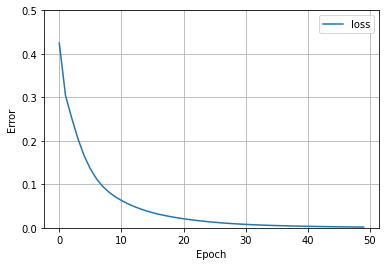

In [13]:
plot_loss(history, ymin=0, ymax=0.5)

In [14]:
# weight matrix of neurons that connect input layers to hidden layer
# get weight returns a list of weights and biases, by taking weight[0] you extract only the weights
weight_matrix = autoencoder.layers[1].get_weights()[0]
weight_matrix = np.asarray(weight_matrix)

def get_latent_context_AE():
    latent_context = np.empty(shape=(df.shape[0], n_latent_context))
    latent_context_labels = [f"latent_{x}" for x in range(n_latent_context)]
    
    # multiply each context sample for the weight matrix
    for idx, s in enumerate(df.loc[:, context_labels].values):
        latent_context[idx] = s @ weight_matrix
    
    # apply activation function
    latent_context = sigmoid(latent_context)
    df_latent_context = pd.DataFrame(latent_context, columns=latent_context_labels)

    return df_latent_context, latent_context_labels

####With PCA

In [15]:
def get_latent_context_PCA(n_latent_context):
    latent_context_labels = [f"latent_{x}" for x in range(n_latent_context)]
    pca = PCA(n_components=n_latent_context)
    pca.fit(df.loc[:,context_labels])
    latent_context = pca.transform(df.loc[:,context_labels])  
    df_latent_context = pd.DataFrame(latent_context, columns=latent_context_labels)
    return df_latent_context, latent_context_labels

#### Run selected method

In [16]:
method = 'AE'
if method == 'PCA': # latent context with PCA
    df_latent_context, latent_context_labels = get_latent_context_PCA(n_latent_context)
    df = pd.concat([df, df_latent_context], axis=1)
elif method == 'AE': # latent context with AE
    df_latent_context, latent_context_labels = get_latent_context_AE()
    df = pd.concat([df, df_latent_context], axis=1)
df

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.001305,0.976896,0.914369,0.599577,0.114146,0.017636,0.997196,0.924460,0.480097,0.013814,0.510822
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.998195,0.800464,0.889886,0.955961,0.914488,0.050380,0.007933,0.906656,0.279149,0.994040,0.172615
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.997458,0.957544,0.031465,0.207913,0.893735,0.938680,0.807353,0.245144,0.913804,0.171387,0.305884
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.158519,0.814041,0.467998,0.119519,0.867447,0.437767,0.384655,0.945900,0.039677,0.725747,0.990565
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.052132,0.671061,0.054495,0.996131,0.561741,0.004581,0.994524,0.989246,0.225741,0.867215,0.868675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.995512,0.976556,0.148583,0.983539,0.630194,0.012011,0.996249,0.847592,0.639146,0.006869,0.866655
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.069387,0.918339,0.027701,0.992352,0.674419,0.144369,0.782460,0.822234,0.978062,0.310383,0.067929
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.998410,0.972603,0.895367,0.941562,0.748977,0.151971,0.007852,0.660177,0.884832,0.237526,0.110042
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.995512,0.976556,0.148583,0.983539,0.630194,0.012011,0.996249,0.847592,0.639146,0.006869,0.866655


### Hierarchical context extraction

In [17]:
def is_leaf(node):
    return node.left is None and node.right is None

# Recursive function to find paths from root node to every leaf node of a binary tree
def root_leaf_paths(node, path, hierarchy):

    if node is None:
        return
 
    path.append(node.id)
 
    if is_leaf(node):
        hierarchy.append(list(path)) # append a complete path to the list of all paths
 
    # Call the functions on left and right subtrees
    root_leaf_paths(node.left, path, hierarchy)
    root_leaf_paths(node.right, path, hierarchy)
 
    # remove current node after left and right subtrees are done
    path.pop()

def hierarchical_clustering(df):
    linked = linkage(df, 'ward')  # linkage matrix
    rootnode, nodelist = to_tree(linked, rd=True) # tree representing the hierarchical clustering
    path = deque() # a path from the root node to a leaf
    hierarchy = []
    root_leaf_paths(rootnode, path, hierarchy)
    longest_path = len(max(hierarchy, key=len)) # find longest path from root to leaf
    hierarchy = [x + [x[-1]]*(longest_path - len(x)) for x in hierarchy] # make path of equal size
    hierarchy.sort(key=lambda x: x[-1]) # sort the list by the last element (datapoints id)
    return hierarchy

In [18]:
# hier_context = hierarchical_clustering(df.loc[:30, latent_context_labels])
# hier_context

[[60, 57, 53, 52, 39, 0, 0, 0],
 [60, 59, 58, 54, 48, 31, 1, 1],
 [60, 59, 56, 42, 2, 2, 2, 2],
 [60, 59, 58, 55, 51, 37, 34, 3],
 [60, 57, 53, 40, 4, 4, 4, 4],
 [60, 59, 58, 54, 48, 43, 5, 5],
 [60, 57, 49, 35, 6, 6, 6, 6],
 [60, 59, 58, 55, 51, 45, 7, 7],
 [60, 57, 53, 40, 8, 8, 8, 8],
 [60, 59, 58, 55, 51, 37, 34, 9],
 [60, 59, 58, 54, 48, 43, 10, 10],
 [60, 59, 56, 50, 47, 32, 11, 11],
 [60, 57, 53, 52, 41, 12, 12, 12],
 [60, 59, 58, 55, 44, 13, 13, 13],
 [60, 57, 53, 52, 41, 14, 14, 14],
 [60, 59, 56, 50, 47, 15, 15, 15],
 [60, 57, 49, 46, 16, 16, 16, 16],
 [60, 57, 49, 46, 33, 17, 17, 17],
 [60, 59, 58, 54, 48, 31, 18, 18],
 [60, 59, 56, 42, 36, 19, 19, 19],
 [60, 59, 58, 55, 51, 37, 20, 20],
 [60, 59, 58, 55, 44, 38, 21, 21],
 [60, 59, 56, 42, 36, 22, 22, 22],
 [60, 59, 58, 55, 51, 45, 23, 23],
 [60, 57, 49, 35, 24, 24, 24, 24],
 [60, 57, 53, 52, 39, 25, 25, 25],
 [60, 59, 56, 50, 47, 32, 26, 26],
 [60, 57, 49, 46, 33, 27, 27, 27],
 [60, 59, 56, 50, 28, 28, 28, 28],
 [60, 59, 58

## Models

In [19]:
# Dictionary that contain evaluation metrics for each model
models_eval_metrics = {}

# embedding vectors length
n_latent_factors_user = n_users // 100
n_latent_factors_item = n_items // 100

# latent factors for matrix factorization
n_latent_factors_mf = n_items // 100

### Matrix factorization
The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize

In [20]:
reader = Reader()
data = Dataset.load_from_df(df[x_labels + [y_label]], reader) # load df in surprise
svd = SVD() # MF model
result = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True) # get result
rmse = np.mean(result['test_rmse'])
mae = np.mean(result['test_mae'])
models_eval_metrics['MF'] = [rmse, mae]

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7497  0.7531  0.7490  0.7506  0.0018  
MAE (testset)     0.6305  0.6344  0.6294  0.6315  0.0021  
Fit time          3.74    3.52    3.50    3.59    0.10    
Test time         0.35    0.22    0.36    0.31    0.07    


### NCF
Multi-layer perceptron without context features

In [21]:
def base_ncf(n_users, n_items, n_latent_factors_user, n_latent_factors_item):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')

    # Item embedding
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding')(item_input)
    item_vec_mlp = Flatten(name='flatten_item')(item_embedding_mlp)

    # User embedding
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding')(user_input)
    user_vec_mlp = Flatten(name='flatten_user')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # Output
    pred_mlp = Dense(1, activation='relu', name='Activation')(dense_3)

    # make and build the model
    return keras.Model([user_input, item_input], pred_mlp)

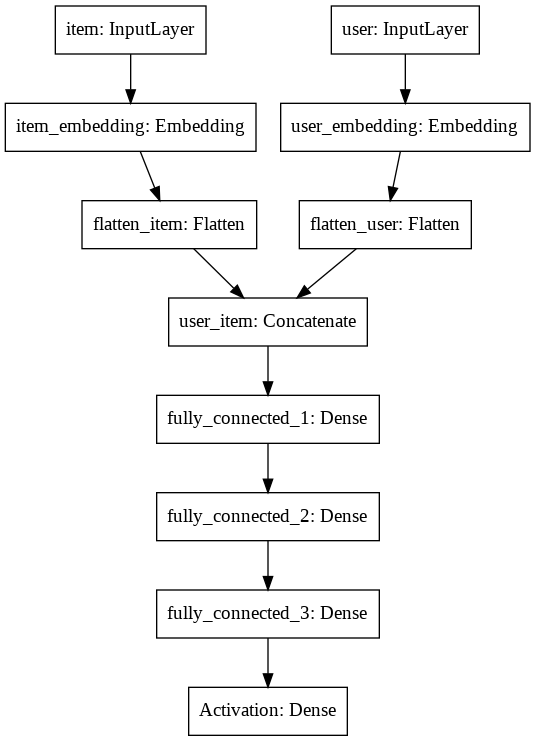

In [22]:
ncf = base_ncf(n_users, n_items, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.0005)
ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

tf.keras.utils.plot_model(ncf)

In [23]:
rmse, mae = kfold_train(ncf, 15, 128, False, df, x_labels, y_label, kf, using_context=False)
models_eval_metrics['NCF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6962478598119668    MAE = 0.5253295905783005
Training on fold 1...
Testing on fold 1...
RMSE = 0.6981397343632632    MAE = 0.5211836923242505
Training on fold 2...
Testing on fold 2...
RMSE = 0.6940922558177484    MAE = 0.515382841262498
Training on fold 3...
Testing on fold 3...
RMSE = 0.688045817390975    MAE = 0.5132832302596508
Training on fold 4...
Testing on fold 4...
RMSE = 0.6785138923879851    MAE = 0.5036183634762281
Training on fold 5...
Testing on fold 5...
RMSE = 0.6876710543057569    MAE = 0.5103083085358793
Training on fold 6...
Testing on fold 6...
RMSE = 0.681822781541953    MAE = 0.5035428951444758
Training on fold 7...
Testing on fold 7...
RMSE = 0.6910650704097209    MAE = 0.5101419821611707
Training on fold 8...
Testing on fold 8...
RMSE = 0.6879669011630869    MAE = 0.5097680958251174
Training on fold 9...
Testing on fold 9...
RMSE = 0.6917660866489579    MAE = 0.5135459583870379


'k-fold RMSE = 0.6895331453841413     k-fold MAE = 0.5126104957954609'

### NeuMF
Multi-layer perceptron + dot product without context features

In [24]:
def base_neumf(n_users, n_items, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')

    # item embedding MF
    item_embedding_mf = Embedding(n_items + 1, n_latent_factors_mf, name='item_embedding_MF')(item_input)
    item_vec_mf = Flatten(name='flatten_item_MF')(item_embedding_mf)

    # User embedding MF
    user_embedding_mf = Embedding(n_users + 1, n_latent_factors_mf,name='user_embedding_MF')(user_input)
    user_vec_mf = Flatten(name='flatten_user_MF')(user_embedding_mf)

    # Dot product MF
    dot = tf.keras.layers.Dot(axes=1)([user_vec_mf, item_vec_mf])

    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding_MLP')(item_input)
    item_vec_mlp = Flatten(name='flatten_item_MLP')(item_embedding_mlp)

    # User embedding MLP
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding_MLP')(user_input)
    user_vec_mlp = Flatten(name='flatten_user_MLP')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item_context_MLP')([item_vec_mlp, user_vec_mlp])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # concat MF and MLP
    concat_mf_mlp = Concatenate(name='MF_MLP')([dense_3, dot])

    # Output
    output = Dense(1, activation='relu',name='Activation')(concat_mf_mlp)

    # make and build the model
    return keras.Model([user_input, item_input], output)

In [25]:
neumf = base_neumf(n_users, n_items, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.0005)
neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

In [26]:
rmse, mae = kfold_train(neumf, 15, 128, False, df, x_labels, y_label, kf, using_context=False)
models_eval_metrics['NEUMF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6389413028548676    MAE = 0.47806217058279493
Training on fold 1...
Testing on fold 1...
RMSE = 0.6278148449042448    MAE = 0.45281393179943047
Training on fold 2...
Testing on fold 2...
RMSE = 0.6237997655958435    MAE = 0.4455225864337168
Training on fold 3...
Testing on fold 3...
RMSE = 0.6237518750702968    MAE = 0.448061911155653
Training on fold 4...
Testing on fold 4...
RMSE = 0.614143222903344    MAE = 0.4388740732719593
Training on fold 5...
Testing on fold 5...
RMSE = 0.6176290729647278    MAE = 0.43977592716971287
Training on fold 6...
Testing on fold 6...
RMSE = 0.6091181581120702    MAE = 0.43214265131575147
Training on fold 7...
Testing on fold 7...
RMSE = 0.6083145376984659    MAE = 0.432937188748363
Training on fold 8...
Testing on fold 8...
RMSE = 0.6116521340241158    MAE = 0.4336290606043625
Training on fold 9...
Testing on fold 9...
RMSE = 0.6183337595384979    MAE = 0.44217157339503066


'k-fold RMSE = 0.6193498673666473     k-fold MAE = 0.4443991074476775'

### ECAM NCF
Multi-layer perceptron with explicit context

In [27]:
def ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # Item embedding
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding')(item_input)
    item_vec_mlp = Flatten(name='flatten_item')(item_embedding_mlp)

    # User embedding
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding')(user_input)
    user_vec_mlp = Flatten(name='flatten_user')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # Output
    pred_mlp = Dense(1, activation='relu', name='Activation')(dense_3)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], pred_mlp)

In [28]:
ecam_ncf = ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.0005)
ecam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_ncf.summary()
#tf.keras.utils.plot_model(ecam_ncf)

In [29]:
rmse, mae = kfold_train(ecam_ncf, 15, 128, False, df, x_labels, y_label, kf, using_context=True, context_labels=context_labels)
models_eval_metrics['ECAM NCF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.682157356501663    MAE = 0.5131719993719788
Training on fold 1...
Testing on fold 1...
RMSE = 0.6812671167548741    MAE = 0.5077583159372472
Training on fold 2...
Testing on fold 2...
RMSE = 0.6825787690929264    MAE = 0.5066918722631794
Training on fold 3...
Testing on fold 3...
RMSE = 0.6761739980786354    MAE = 0.5038064065154576
Training on fold 4...
Testing on fold 4...
RMSE = 0.6648384236144862    MAE = 0.49266851331325906
Training on fold 5...
Testing on fold 5...
RMSE = 0.6748647846390421    MAE = 0.5003355334029814
Training on fold 6...
Testing on fold 6...
RMSE = 0.6678572245253074    MAE = 0.49329694170186356
Training on fold 7...
Testing on fold 7...
RMSE = 0.6811697932167052    MAE = 0.5012355126010367
Training on fold 8...
Testing on fold 8...
RMSE = 0.6734452800047538    MAE = 0.4987365343006246
Training on fold 9...
Testing on fold 9...
RMSE = 0.6767791671999893    MAE = 0.5010748368763989


'k-fold RMSE = 0.6761131913628383     k-fold MAE = 0.5018776466284027'

### ECAM NeuMF
Multi-layer perceptron + dot product with explicit context

In [30]:
def neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # item embedding MF
    item_embedding_mf = Embedding(n_items + 1, n_latent_factors_mf, name='item_embedding_MF')(item_input)
    item_vec_mf = Flatten(name='flatten_item_MF')(item_embedding_mf)

    # User embedding MF
    user_embedding_mf = Embedding(n_users + 1, n_latent_factors_mf,name='user_embedding_MF')(user_input)
    user_vec_mf = Flatten(name='flatten_user_MF')(user_embedding_mf)

    # Dot product MF
    dot = tf.keras.layers.Dot(axes=1)([user_vec_mf, item_vec_mf])

    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding_MLP')(item_input)
    item_vec_mlp = Flatten(name='flatten_item_MLP')(item_embedding_mlp)

    # User embedding MLP
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding_MLP')(user_input)
    user_vec_mlp = Flatten(name='flatten_user_MLP')(user_embedding_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item_context_MLP')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    dense_2 = Dense(4, name='fully_connected_2')(dense)
    dense_3 = Dense(2, name='fully_connected_3')(dense_2)

    # concat MF and MLP
    concat_mf_mlp = Concatenate(name='MF_MLP')([dense_3, dot])

    # Output
    output = Dense(1, activation='relu',name='Activation')(concat_mf_mlp)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], output)

In [31]:
ecam_neumf = neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.0005)
ecam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_neumf.summary()
#tf.keras.utils.plot_model(ecam_neumf)

In [32]:
rmse, mae = kfold_train(ecam_neumf, 15, 128, False, df, x_labels, y_label, kf, using_context=True, context_labels=context_labels)
models_eval_metrics['ECAM NEUMF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.622895296698481    MAE = 0.463129471055493
Training on fold 1...
Testing on fold 1...
RMSE = 0.6066839733809085    MAE = 0.43617325459530465
Training on fold 2...
Testing on fold 2...
RMSE = 0.6080292978487456    MAE = 0.4324931809525803
Training on fold 3...
Testing on fold 3...
RMSE = 0.6040087201500933    MAE = 0.43273483245611993
Training on fold 4...
Testing on fold 4...
RMSE = 0.5964603448880361    MAE = 0.424602495364199
Training on fold 5...
Testing on fold 5...
RMSE = 0.5989339154154495    MAE = 0.42560967188004495
Training on fold 6...
Testing on fold 6...
RMSE = 0.5949384717218978    MAE = 0.4186557360932154
Training on fold 7...
Testing on fold 7...
RMSE = 0.5928002517184138    MAE = 0.4205045691426673
Training on fold 8...
Testing on fold 8...
RMSE = 0.5941631162223466    MAE = 0.42037376910031465
Training on fold 9...
Testing on fold 9...
RMSE = 0.5983924346659751    MAE = 0.42571299654764366


'k-fold RMSE = 0.6017305822710347     k-fold MAE = 0.42999899771875827'

### UCAM NCF
Multi-layer perceptron with latent context

In [33]:
ucam_ncf = ncf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.005)
ucam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ucam_ncf.summary()
#tf.keras.utils.plot_model(ucam_ncf)

In [34]:
rmse, mae = kfold_train(ucam_ncf, 15, 128, False, df, x_labels, y_label, kf, 
                        using_context=True, context_labels=latent_context_labels)
models_eval_metrics['UCAM NCF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6856713015418128    MAE = 0.5172534517057156
Training on fold 1...
Testing on fold 1...
RMSE = 0.6843845184959414    MAE = 0.5107049276640616
Training on fold 2...
Testing on fold 2...
RMSE = 0.6833507112063861    MAE = 0.5080243022591047
Training on fold 3...
Testing on fold 3...
RMSE = 0.6768773218853934    MAE = 0.5058926991142834
Training on fold 4...
Testing on fold 4...
RMSE = 0.6674521640864451    MAE = 0.4955435184100679
Training on fold 5...
Testing on fold 5...
RMSE = 0.678025335032389    MAE = 0.5022588789434906
Training on fold 6...
Testing on fold 6...
RMSE = 0.6688199882364911    MAE = 0.4947002922053629
Training on fold 7...
Testing on fold 7...
RMSE = 0.6795037983206932    MAE = 0.5015414084503605
Training on fold 8...
Testing on fold 8...
RMSE = 0.6759459645426856    MAE = 0.5010363488654939
Training on fold 9...
Testing on fold 9...
RMSE = 0.6803853652112642    MAE = 0.5027574726268141


'k-fold RMSE = 0.6780416468559501     k-fold MAE = 0.5039713300244755'

### UCAM NeuMF
Multi-layer perceptron + dot product with latent context

In [35]:
ucam_neumf = neumf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.0005)
ucam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

In [36]:
rmse, mae = kfold_train(ucam_neumf, 15, 128, False, df, x_labels, y_label, kf, 
                        using_context=True, context_labels=latent_context_labels)
models_eval_metrics['UCAM NEUMF'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6251081976695114    MAE = 0.46525753502929124
Training on fold 1...
Testing on fold 1...
RMSE = 0.6069532378484762    MAE = 0.4360696278690884
Training on fold 2...
Testing on fold 2...
RMSE = 0.610663378869054    MAE = 0.43443681453926114
Training on fold 3...
Testing on fold 3...
RMSE = 0.6053271672845051    MAE = 0.43509485772378137
Training on fold 4...
Testing on fold 4...
RMSE = 0.598636118960358    MAE = 0.4256371990305242
Training on fold 5...
Testing on fold 5...
RMSE = 0.6022681902001469    MAE = 0.428530742872208
Training on fold 6...
Testing on fold 6...
RMSE = 0.5946587185562355    MAE = 0.41933622089625583
Training on fold 7...
Testing on fold 7...
RMSE = 0.5952411092538626    MAE = 0.42228886655683506
Training on fold 8...
Testing on fold 8...
RMSE = 0.5975509748239275    MAE = 0.4226133733303783
Training on fold 9...
Testing on fold 9...
RMSE = 0.6001868335475017    MAE = 0.42685216697516537


'k-fold RMSE = 0.6036593927013579     k-fold MAE = 0.4316117404822789'

## Performance comparison

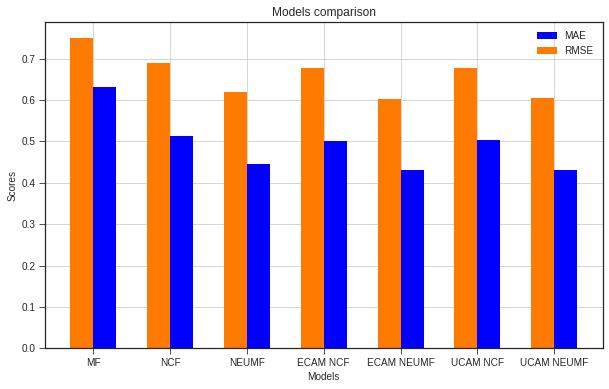

Name: MF      	      RMSE: 0.7505975056634542      	      MAE: 0.6314524760252739
Name: NCF      	      RMSE: 0.6895331453841413      	      MAE: 0.5126104957954609
Name: NEUMF      	      RMSE: 0.6193498673666473      	      MAE: 0.4443991074476775
Name: ECAM NCF      	      RMSE: 0.6761131913628383      	      MAE: 0.5018776466284027
Name: ECAM NEUMF      	      RMSE: 0.6017305822710347      	      MAE: 0.42999899771875827
Name: UCAM NCF      	      RMSE: 0.6780416468559501      	      MAE: 0.5039713300244755
Name: UCAM NEUMF      	      RMSE: 0.6036593927013579      	      MAE: 0.4316117404822789


In [38]:
n_models = len(models_eval_metrics) # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 
rmse = [x[0] for x in models_eval_metrics.values()]
mae = [x[1] for x in models_eval_metrics.values()]

index = np.arange(n_models)
bar_width = 0.30
plt.figure(figsize=(10,6))

# MAE bar
rect1 = plt.bar(index + bar_width, mae, bar_width,
color='b',
label='MAE')

# RMSE bar
rect2 = plt.bar(index, rmse, bar_width,
color='#ff7b00',
label='RMSE')

plt.style.use('seaborn-ticks') # readable chart on dark editor
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Models comparison')
plt.xticks(index + bar_width/2, models_name) # labels position
plt.legend()
plt.grid(True)
plt.show()

for name, rmse, mae in zip(models_name, rmse, mae):
    print(f"Name: {name}      \t      RMSE: {rmse}      \t      MAE: {mae}")